# Attention is All You Need - The Annotated Version

In [ ]:
# https://nlp.seas.harvard.edu/annotated-transformer/
# https://medium.com/we-talk-data/in-depth-guide-on-pytorchs-nn-transformer-901ad061a195
# https://github.com/gordicaleksa/pytorch-original-transformer/tree/main
# https://www.youtube.com/watch?v=n9sLZPLOxG8
# https://www.youtube.com/watch?v=px4rtkWHFvM

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from dataclasses import dataclass
from tqdm import tqdm

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

# Part 1: Model Architecture (Section 3)

Transformers -> GPT series config compatibility
- src_vocab -> vocab_size ... total number of tokens for inputs
- tgt_vocab -> vocab_size ... total number of tokens for outputs
- d_model -> n_embed ........ embedding dimension
- d_model-> block_size ....... max sequence length
- n_head -> n_head .............. number of heads
- n_encoder -> n_layer ........ number of layers
- n_decoder -> n_layer ........ number of layers
- d_ff -> 4 * n_embed .......... FFN inner-layer dimensionality
- dropout -> none

# Attention (Section 3.2)

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call our particular attention "Scaled Dot-Product Attention". The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.

The dot product can result in vectors with very positive and very negative numbers inside it, and the problem is that the softmax (applied few lines below) will converge to one-hot-like vectors, so we scale the Attention matrix with the square root of head size to "normalize" its variance and keep weights fairly diffuse before softmax.

In practice, we compute the Attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V. We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$

- Query -> what we are looking for
- Key     -> our content
- Value -> token information, what will communicate

**Attention scores ($QK^T$, "affinities"):** If the query and key are aligned they will interact to each other with a very high amount and then we will learn more about that specific token as opposed to any token in the sequence.

# Multi-Head Attention (Section 3.2.2)

Multi-Head Attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single Attention head, averaging inhibits this.

$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$

where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.

In this work we employ $h=8$ parallel Attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of Single-Head Attention with full dimensionality.

Dropout is applied after computing the Scaled Dot-Product Attention but before adding it to the residual connection.

In [3]:
class MultiHeadedAttention(nn.Module):
    """
    Defining the Multi-Headed Attention operation into a single class.
    """

    def __init__(self, n_embed, n_head, dropout) -> None:
        super(MultiHeadedAttention, self).__init__()
        assert n_embed % n_head == 0, "n_embed must be divisible by n_head"
        self.n_embed= n_embed
        self.n_head = n_head
        self.d_head = n_embed // n_head
        # query, key, value projections
        self.q_proj= nn.Linear(n_embed, n_embed)
        self.k_proj= nn.Linear(n_embed, n_embed)
        self.v_proj= nn.Linear(n_embed, n_embed)
        # output projection
        self.o_proj= nn.Linear(n_embed, n_embed)
        # regularization
        self.dropout= nn.Dropout(p=dropout)


    def forward(self, query, key, value, mask=None):
        B, T, C= query.size() # batch_size, sequence length, embedding dim (d_model)
        assert C == self.n_embed, "Input embedding dimension must match model embedding dimension"
        # 1. calculate query, key, values for all heads and move heads forward to be the batch dim
        # nh is 'number of heads', dh is 'head dim'
        q= self.q_proj(query)
        k= self.k_proj(key)   # q,k,v -> (B, T, C)
        v= self.v_proj(value)
        # 2. reshape for Multi-Head Attention -- q,k,v view -> (B, T, nh, dh)
        q= q.view(B, -1, self.n_head, self.d_head).transpose(1, 2)
        k= k.view(B, -1, self.n_head, self.d_head).transpose(1, 2) # q,k,v transp -> (B, nh, T, dh)
        v= v.view(B, -1, self.n_head, self.d_head).transpose(1, 2)
        # 3. this is the original implementation of Attention - the 'scaled dot product'
        # Attention (materializes the large (T, T) matrix for all the queries and keys)
        attn= (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.d_head))
        # apply Attention mask (when the mask is not None)
        if mask is not None:
            attn= attn.masked_fill(mask== 0, float('-inf'))
        # normalize Attention scores
        attn= F.softmax(attn, dim=-1)
        attn= self.dropout(attn)
        # 4. compute Attention output
        y= attn @ v # (B, nh, T, T) x (B, nh, T, dh) -> (B, nh, T, dh)
        # 5. concatenate multi-head outputs
        y= y.transpose(1, 2).contiguous().view(B, T, C) # re-assembly all head outputs side by side
        # 6. output projection
        y= self.o_proj(y)

        return y, attn


The Transformer uses Multi-Head Attention in three different ways:

- The encoder contains Self-Attention layers. In a self-attention layer all of the keys, values and queries come from the same source, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

- Similarly, Self-Attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position (in an autoregressive manner). We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot-product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections (using a triangular causal mask).

- In "Encoder-Decoder Attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder (Cross-Attention). This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models.

In summary:

- Self-Attention: query, key, and value come from the same source (i.e., x from the previous module)

- Cross-Attention: query, key, and value come from different sources (query comes from x of the previous module; key and value come from encoder's memory).

- Multi-Head Attention is applying multiple Attentions in parallel and concatenating their results. If you're familiar with convolutions Multi-Head Attention is kind of like a group convolution, because instead of having one large convolution we do convolutions in groups.

# Position-wise Feed-Forward Network (Section 3.3)

In addition to Attention modules, each of the layers (blocks) in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$.

It's position-wise because this feed forward net will be independently applied to every token's representation. This net will basically be applied independently to every token's representation (you can think of it as if there was a nested for-loop going over the batch size and max token sequence length dimensions and applied this network to token representations. PyTorch does this auto-magically behind the scenes.

Dropout is applied after the activation function (ReLU) in the feedforward network and before adding the residual connection.

In [4]:
class PositionwiseFeedForward(nn.Module):
    """
    Defining the FeedForward Network.
    It is a two linear projectons sandwiched in between the ReLU nonlinearity.
    """

    def __init__(self, d_model, d_ff, dropout) -> None:
        super(PositionwiseFeedForward, self).__init__()
        self.ffn_in= nn.Linear(d_model, d_ff)
        self.relu= nn.ReLU(inplace=True)
        self.ffn_proj= nn.Linear(d_ff, d_model)
        self.dropout= nn.Dropout(p=dropout)


    def forward(self, x):
        x= self.ffn_in(x)
        x= self.relu(x)
        x= self.dropout(x)
        x= self.ffn_proj(x)

        return x


The Attention modules did the communication, allowing tokens to look at each other and find high affinities, but they didn't have time to consider what they found from the other tokens. In other words, Self-Attention is the communication, and once they've gathered all the data, they need to think about that data individually.
- Attention do the communication
- FeedForward do the computation

# Encoder and Decoder Stacks (Section 3.1)

A standard Encoder-Decoder architecture. Here, the encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $z= (z_1, ..., z_n)$. Given $z$, the decoder then generates an output sequence $(y_1, ...,y_m)$ of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.

Layer normalization is applied to stabilize the training process. It normalizes the input across the features, ensuring that the outputs have a stable distribution. Dropout is applied after the final output projection of the Multi-Head Attention and the feedforward network outputs.

In [5]:
class LayerNorm(nn.Module):
    """
    Construct a LayerNorm module (nn.LayerNorm)
    """

    def __init__(self, norm_shape, eps=1e-6) -> None:
        super(LayerNorm, self).__init__()
        self.weight= nn.Parameter(torch.ones(norm_shape))
        self.bias= nn.Parameter(torch.zeros(norm_shape))
        self.eps= eps


    def forward(self, x):
        # calculate mean and variance along the last axis
        mean= x.mean(-1, keepdim=True)
        stdv= x.std(-1, keepdim=True)
        # normalize the inputs
        norm= self.weight * (x - mean) / (stdv + self.eps) + self.bias

        return norm


# Encoder

Each encoder block has two sub-layers. The first is a Multi-Head Self-Attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

The paper employ a residual connection around each of the two sub-layers, followed by layer normalization. That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself. Dropout is applied the output of each sub-layer, before it is added to the sub-layer input and normalized.

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.

**NOTE:** Very few details about the Transformer have changed in the last five years, but there is something slightly departs from the original paper. You see in Figure 1 that Add and Norm is applied after (Post-LN) the transformation (Multi-Head Attention). But now it is more common to apply LayerNorm before (Pre-LN) the transformation, so there is a reshuffling of the Layer Norm. This is called pre-norm formulation and that is the one we are going to implement as well.

In [6]:
class EncoderBlock(nn.Module):
    """
    The Decoder block is made of Self-Attention and FeedForward network.
    Pre-normalization: LayerNorms are before the application of Attention and FeedForward
    in order to keep a clean residual stream all the way down to the input tokens.
    """

    def __init__(self, d_model, n_head, d_ff, dropout) -> None:
        super(EncoderBlock, self).__init__()
        self.ln_1= LayerNorm(d_model)
        self.attn= MultiHeadedAttention(d_model, n_head, dropout)
        self.dropout1= nn.Dropout(p=dropout)
        self.ln_2= LayerNorm(d_model)
        self.ffn= PositionwiseFeedForward(d_model, d_ff, dropout)
        self.dropout2= nn.Dropout(p=dropout)


    def forward(self, x, src_mask=None):
        # pre-norm encoder block connections
        x_norm = self.ln_1(x)
        attn, _= self.attn(x_norm, x_norm, x_norm, mask=src_mask)
        x= x + self.dropout1(attn)

        x_norm= self.ln_2(x)
        ffn= self.ffn(x_norm)
        x= x + self.dropout2(ffn)

        return x


According the paper, the encoder is composed of a stack of N=6 identical encoder blocks (or layers).

In [7]:
class Encoder(nn.Module):
    """
    Core encoder module is a stack of N encoder blocks (layers).
    """

    def __init__(self, n_encoder=6, d_model=512, n_head=8, d_ff=2048, dropout=0.1) -> None:
        super(Encoder, self).__init__()
        self.e_nx= nn.ModuleList([
            EncoderBlock(d_model, n_head, d_ff, dropout) for _ in range(n_encoder)
        ])
        self.norm= LayerNorm(d_model)


    def forward(self, x, src_mask=None):
        # pass the input (and mask) through each encoder block
        for block in self.e_nx:
            x= block(x, src_mask)
        # forward the final layerNorm to the decoder
        x= self.norm(x)

        return x


# Decoder

The first Attention module of a decoder is a Masked Self-Attention. The purpose of a Masked Self-Attention in the Decoder is to ensure that, during training or inference, a token can only attend to itself and earlier tokens in the sequence. This maintains the autoregressive property required for generation tasks (a triangular causal mask is applied).

In addition to the two sub-modules present in each encoder block, each decoder block inserts a third sub-module (placed between the masked Self-Attention and Feed Forward), which performs Multi-Head Attention over the Attention output (queries and keys scaled dot product) from the encoder stack (i.e., a Cross-Attention). Here, the outputs from the first Multi-Headed Attention module of the decoder serve as the value.

There is no causal mask in Cross-Attention: The encoder output is fixed for the entire sequence, representing the input context. There's no need to enforce an autoregressive constraint because the encoder output is not dependent on the tokens generated by the decoder.

In summary, the decoder's Cross-Attention module takes:
- Query ($Q$) from the decoder output (the Self-Attention layer's output).
- Key ($K$) and Value ($V$) from the encoder's output (encoder memory).

Similar to the encoder, we employ layer normalization (Pre-LN) and residual connections around each of the sub-layers.

In [8]:
class DecoderBlock(nn.Module):
    """
    The Decoder block is made of masked Self-Attention, Cross-Attention, and FeedForward net.
    Pre-normalization: LayerNorms are before the application of Attention and FeedForward
    in order to keep a clean residual stream all the way down to the input tokens.
    """

    def __init__(self, d_model, n_head, d_ff, dropout) -> None:
        super(DecoderBlock, self).__init__()
        self.ln_1= nn.LayerNorm(d_model)
        self.mask_attn= MultiHeadedAttention(d_model, n_head, dropout)
        self.dropout1= nn.Dropout(p=dropout)
        self.ln_2= nn.LayerNorm(d_model)
        self.cross_attn= MultiHeadedAttention(d_model, n_head, dropout)
        self.dropout2= nn.Dropout(p=dropout)
        self.ln_3= nn.LayerNorm(d_model)
        self.ffn= PositionwiseFeedForward(d_model, d_ff, dropout)
        self.dropout3= nn.Dropout(p=dropout)


    def forward(self, x, memory_enc, causal_mask, memory_mask=None):
        # masked self-attention module of the decoder uses the causal triangular mask
        x_norm = self.ln_1(x)
        attn, _= self.mask_attn(x_norm, x_norm, x_norm, mask=causal_mask)
        x= x + self.dropout1(attn)

        x_norm = self.ln_2(x)
        attn, _= self.cross_attn(x_norm, memory_enc, memory_enc, mask=memory_mask)
        x= x + self.dropout2(attn)

        x_norm= self.ln_3(x)
        ffn= self.ffn(x_norm)
        x= x + self.dropout3(ffn)

        return x


The decoder is also composed of a stack of N=6 identical blocks (layers).

We also modify the Self-Attention module in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [9]:
class Decoder(nn.Module):
    """
    Decoder module is a stack of N decoder blocks with masking.
    """

    def __init__(self, n_decoder=6, d_model=512, block_size=512, n_head=8, d_ff=2048,
                 dropout=0.1) -> None:
        super(Decoder, self).__init__()
        self.d_nx= nn.ModuleList([
            DecoderBlock(d_model, n_head, d_ff, dropout) for _ in range(n_decoder)
        ])
        self.norm= LayerNorm(d_model)
        # register_buffer performs Masked Attention on the outputs, so that positions depend on
        # the past only -- create a lower triangular matrix (2-D tensor)
        self.register_buffer('causal_mask',
            torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size)
        )


    def forward(self, x, memory_enc, memory_mask=None):
        B, T, C= x.size() # batch_size, sequence length, embedding dim (d_model)
        causal_mask= self.causal_mask[:,:,:T,:T]

        # pass the input, memory from the encoder (and mask) through each decoder block
        for block in self.d_nx:
            x= block(x, memory_enc, causal_mask, memory_mask)
        # forward the final layerNorm to the generator
        x= self.norm(x)

        return x


# Embeddings and Softmax (Section 3.4)

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation. In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.

In [10]:
class Embeddings(nn.Module):
    """
    Convert the input/output tokens to vectors.
    """

    def __init__(self, vocab_size, d_model) -> None:
        super(Embeddings, self).__init__()
        self.d_model= d_model
        # token embedding table
        self.wte= nn.Embedding(vocab_size, d_model)


    def forward(self, x):
        # (stated in the paper) multiply the embedding weights by the square root of d_model
        x= self.wte(x) * math.sqrt(self.d_model)

        return x  # (B, T) -> (B, T, C) where C is the model dimension d_model


In [11]:
class Generator(nn.Module):
    """
    Define standard linear + softmax generation step.
    """

    def __init__(self, d_model, vocab_size) -> None:
        super(Generator, self).__init__()
        self.projection_head= nn.Linear(d_model, vocab_size)


    def forward(self, x):
        logits= self.projection_head(x)
        # using log_softmax as PyTorch's nn.KLDivLoss expects log probabilities
        log_probs= F.log_softmax(logits, dim=-1)

        return logits, log_probs


# Positional Encoding (Section 3.5)

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed.

In this work, we use sine and cosine functions of different frequencies:

$$
    PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \\                                                                                      
    PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})                       
$$

where pos is the position and i is the dimension.

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. Dropout is typically applied to positional encodings when added to embeddings.

In [12]:
class PositionalEncoding(nn.Module):
    """
    Implement the PE function.
    """

    def __init__(self, block_size, d_model, dropout, const_val=10000.0) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout= nn.Dropout(p=dropout)
        # create a long tensor of block_size positions
        position= torch.arange(0, block_size).unsqueeze(1)
        frequencies= torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(const_val) / d_model)
        )
        # create an empty placeholder
        wpe= torch.zeros(block_size, d_model)
        # itterating over each element in the sequence using sin and cos
        wpe[:, 0::2]= torch.sin(position * frequencies)
        wpe[:, 1::2]= torch.cos(position * frequencies)
        # register_buffer so it's saved in the model state_dict but not optimized
        self.register_buffer('wpe', wpe.unsqueeze(0))


    def forward(self, x):
        x= x + self.wpe[:, : x.size(1)].requires_grad_(False).to(x.device)
        # (stated in the paper) dropout to the sum of positional encodings and token embeddings
        return self.dropout(x)


# Building The Full Transformer Model

The Nx (n_encoder=6 and n_decoder) here simply represents that this block is chain-repeated N times. So basically you are stacking the block back-to-back and passing the input from the previous block to the next one. This is a way to make the neural network deeper. Let's say N=5. Do we feed the output of each encoder layer to the corresponding decoder layer? No. Basically you run the encoder all the way through once and only once. Then you just take that representation and feed the same thing to every one of the 5 decoder layers.

In [13]:
class Transformer(nn.Module):
    """
    Construct a Transformer model from hyperparameters.
    """

    def __init__(self, src_vocab, tgt_vocab, d_model=512, block_size=512, n_head=8,
                 n_encoder=6, n_decoder=6, d_ff=2048, dropout=0.1) -> None:
        super(Transformer, self).__init__()
        self.src_vocab= src_vocab
        self.tgt_vocab= tgt_vocab
        self.d_model= d_model

        c= copy.deepcopy
        positional_enc= PositionalEncoding(block_size, d_model, dropout)

        self.src_embed= nn.Sequential(Embeddings(src_vocab, d_model), c(positional_enc))
        self.encoder= Encoder(n_encoder, d_model, n_head, d_ff, dropout)
        self.tgt_embed= nn.Sequential(Embeddings(tgt_vocab, d_model), c(positional_enc))
        self.decoder= Decoder(n_decoder, d_model, block_size, n_head, d_ff, dropout)
        self.generator= Generator(d_model, tgt_vocab)

        # initialize parameters with Glorot / fan_avg
        # values are scaled by the gain parameter. no gradient is recorded for this operation
        for p in self.parameters():
            if p.dim()> 1:
                nn.init.xavier_normal_(p)


    # modularize into encode/decode functions for optimizing the decoding/translation process
    def encode(self, src, src_padding_mask=None):
        # embedding and positional encoding for source/inputs
        src= self.src_embed(src)
        # forward pass through the encoder
        encoded= self.encoder(src, src_padding_mask)

        return encoded


    def decode(self, tgt, memory, memory_padding_mask=None):
        # embedding and positional encoding for target/outputs
        tgt= self.tgt_embed(tgt)
        # forward pass through the decoder
        decoded= self.decoder(tgt, memory, memory_padding_mask)

        return decoded


    def forward(self, src, tgt, src_padding_mask=None, tgt_padding_mask=None):
        # take in and process masked src and target sequences.
        encoded= self.encode(src, src_padding_mask)
        decoded= self.decode(tgt, encoded, tgt_padding_mask)
        # after this line we'll have a shape (B, T, V), where V is the target vocab size,
        # generator does a simple linear projection followed by log_softmax
        logits, log_probs= self.generator(decoded)
        # reshape into (B*T, V) as that's suitable for passing it into KL Div loss
        logits= logits.reshape(-1, logits.size(-1))
        log_probs= log_probs.reshape(-1, log_probs.size(-1))

        return logits, log_probs


    def generate(self, src, src_padding_mask, max_new_tokens, start_symbol):
        """ This code predicts a translation using greedy decoding for simplicity """
        self.eval()
        with torch.no_grad():
            # src is (B, T) tensor of indices in the current context
            memory= self.encode(src, src_padding_mask)
            tgt= torch.zeros(1, 1).fill_(start_symbol).type_as(src)

            for _ in range(max_new_tokens -1):
                # get the decoder's predictions
                out= self.decode(tgt, memory, src_padding_mask)
                # focus only on thee last time step and apply softmax to get probabilities
                _, log_probs= self.generator(out[:, -1])  # becomes (B, C)
                # sample from the distribution
                _, next_word= torch.max(log_probs, dim=1) # (B, 1)
                next_word= next_word.data[0]
                # append sampled index to the running sequence
                tgt= torch.cat( # (B, T+1)
                    [tgt, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
                )

        return tgt


In [14]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')


In [ ]:
# --- baseline model ---
vocab_size= 11
d_model= 512
block_size= d_model
n_head= 8
n_encoder= 6
n_decoder= n_encoder
d_ff= 4 * d_model
dropout= 0.1

model= Transformer(vocab_size, vocab_size, d_model, block_size, n_head,
                   n_encoder, n_decoder, d_ff, dropout).to(device)

count_parameters(model)

Number of parameters: 44157451


In [ ]:
# --- large model ---
vocab_size= 11
d_model= 1024
block_size= d_model
n_head= 16
n_encoder= 6
n_decoder= n_encoder
d_ff= 4 * d_model
dropout= 0.3

model= Transformer(vocab_size, vocab_size, d_model, block_size, n_head,
                   n_encoder, n_decoder, d_ff, dropout).to(device)

count_parameters(model)

Number of parameters: 176395275


In [ ]:
# --- larger model ---
vocab_size= 50257 # GPT-2/3 total number of tokens
d_model= 768
block_size= 1024
n_head= 12
n_encoder= 12
n_decoder= n_encoder
d_ff= 4 * d_model

model= Transformer(vocab_size, vocab_size, d_model, block_size, n_head,
                   n_encoder, n_decoder, d_ff).to(device)

count_parameters(model)

model

Number of parameters: 314321233


Transformer(
  (src_embed): Sequential(
    (0): Embeddings(
      (wte): Embedding(50257, 768)
    )
    (1): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): Encoder(
    (e_nx): ModuleList(
      (0-11): 12 x EncoderBlock(
        (ln_1): LayerNorm()
        (attn): MultiHeadedAttention(
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (o_proj): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (ln_2): LayerNorm()
        (ffn): PositionwiseFeedForward(
          (ffn_in): Linear(in_features=768, out_features=3072, bias=True)
          (relu): ReLU(inplace=True)
          (ffn_proj): Linear(in_features=3072, out_features=768, bias=True)
         

# Inference

Here we make some forward steps to generate predictions of the model. We try to use our transformer to memorize the input. As you will see the output is randomly generated due to the fact that the model is not trained yet. In the next part of this tutorial we will build the training function and try to train our model to memorize the numbers from 1 to 10.

In [15]:
def create_padding_mask(seq, pad_token_id):
    """ mask out padding tokens (0 for padding, 1 for valid tokens)
    src/tgt_padding_mask must have a shape (B, 1, 1, T) """

    return (seq != pad_token_id).unsqueeze(1).unsqueeze(2)


In [16]:
def inference_test(model, device):
    src= torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]).to(device) # (B, T)
    src_mask= create_padding_mask(src, pad_token_id=0).to(device)       # (B, 1, 1, T)
    max_new_tokens= src.shape[1] + 1
    start_symbol= 0

    ys= model.generate(src, src_mask, max_new_tokens, start_symbol)

    print('Example Untrained Model Prediction:', ys)


In [17]:
src_vocab_size= 11
trg_vocab_size= 11

for _ in range(10):
    test_model= Transformer(src_vocab_size, trg_vocab_size, n_encoder=2, n_decoder=2).to(device)
    inference_test(test_model, device)


Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
Example Untrained Model Prediction: tensor([[0, 6, 1, 5, 1, 8, 1, 8, 1, 8, 1]], device='cuda:0')
Example Untrained Model Prediction: tensor([[ 0, 10,  9,  1,  9,  9,  9,  9,  9,  9,  9]], device='cuda:0')
Example Untrained Model Prediction: tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]], device='cuda:0')
Example Untrained Model Prediction: tensor([[ 0,  9,  9,  9,  3,  3,  7, 10,  3,  3,  3]], device='cuda:0')
Example Untrained Model Prediction: tensor([[0, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7]], device='cuda:0')
Example Untrained Model Prediction: tensor([[0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0]], device='cuda:0')
Example Untrained Model Prediction: tensor([[ 0, 10, 10, 10, 10,  1,  6,  1,  6,  1,  6]], device='cuda:0')
Example Untrained Model Prediction: tensor([[0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]], device='cuda:0')
Example Untrained Model Prediction: tensor([[0, 9, 0, 9, 0, 9, 0, 9, 0, 9, 0]], device='cuda:0

In [18]:
# example of a complete forward pass
test_model= Transformer(src_vocab_size, trg_vocab_size, n_encoder=2, n_decoder=2).to(device)

src_tokens_batch= torch.randint(1, 10, size=(2, 10), device=device)
trg_tokens_batch= torch.randint(1, 10, size=(2, 10), device=device)

test_model.eval()
logits, log_probs= test_model(src_tokens_batch, trg_tokens_batch)

print(f'log_probs: {log_probs.shape}')

log_probs: torch.Size([20, 11])


# A First Example

A very simplified training procedure using synthetic data. Given a random set of input tokens from a small vocabulary, the goal is to train the Transformer to generate back ordered sequences.

In [19]:
def data_batch_gen(vocab_size, batch_size, block_size, device):
    """ Generate random sequences and their sorted counterparts """

    data= []
    for _ in range(batch_size):
        seq= [np.random.randint(1, vocab_size) for _ in range(block_size)]
        sorted_seq= sorted(seq)
        data.append((seq, sorted_seq))

    x, y= zip(*data)

    return torch.tensor(x).to(device), torch.tensor(y).to(device)


In [20]:
from tqdm import tqdm

def lets_train_it(model, optimizer, max_steps, device):
    PAD_TOKEN_ID= 0
    criterion= nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=PAD_TOKEN_ID)

    losses= torch.zeros(max_steps)
    # --- training loop ---
    for step in tqdm(range(max_steps)):
        # sample a batch of data with 10 digits per sequence
        xb, yb= data_batch_gen(model.src_vocab, 64, 10, device)

        # shift target to create input-output pairs for the decoder
        yb_input = yb[:, :-1]
        yb_output= yb[:, 1:]

        # --- generate masks ---
        src_mask   = create_padding_mask(xb, PAD_TOKEN_ID) # encoder padding mask
        memory_mask= create_padding_mask(xb, PAD_TOKEN_ID) # cross-attention mask

        # --- forward pass and get loss ---
        model.train(True)
        logits, _= model(xb, yb_input, src_mask, memory_mask)
        loss= criterion(logits, yb_output.reshape(-1))
        losses[step]= loss.item()

        # --- backward pass to calculate the gradients ---
        optimizer.zero_grad()
        loss.backward()

        # --- update the parameters using the gradient ---
        optimizer.step()

    return losses


100%|██████████| 1000/1000 [00:31<00:00, 31.27it/s]


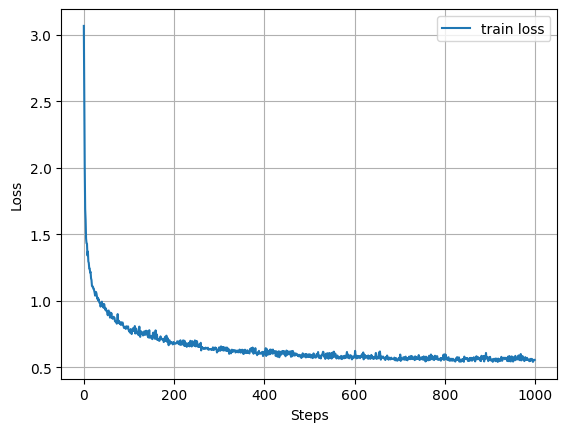

In [22]:
test_model= Transformer(src_vocab_size, trg_vocab_size, n_encoder=2, n_decoder=2).to(device)

optimizer= torch.optim.AdamW(test_model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)

losses= lets_train_it(test_model, optimizer, max_steps=1000, device=device)

plt.plot(losses, label='train loss')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [25]:
src= torch.LongTensor([[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]]).to(device)
src_mask= create_padding_mask(src, pad_token_id=0).to(device)
max_new_tokens= src.shape[1] + 1
start_symbol= 0

ys= test_model.generate(src, src_mask, max_new_tokens, start_symbol)

print(f'Example Trained Model Prediction: {ys}\n')

count_parameters(test_model)

Example Trained Model Prediction: tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]], device='cuda:0')

Number of parameters: 14731787


# Part 2: Model Training (Section 5)

This section describes the training regime for our models. First we define a batch object that holds the src and target sentences for training, as well as constructing the masks.

See GPT_2.ipynb for datails on TF32, kernel fusion, Gradient accumulation, and so on.

# Batches and Masking (Section 5.1)

# Optimizer (Section 5.3)

We used the Adam optimizer with $\beta_1= 0.9$, $\beta_2= 0.98$ and $\epsilon=10^{-9}$. We varied the learning rate over the course of training, according to the formula:

$$
lrate= d_{\text{model}}^{-0.5}\cdot \min(step\_num^{-0.5}, step\_num\cdot warmup\_steps^{-1.5})
$$

This corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. We used $warmup\_steps = 4000$.

**Note:** This part is very important. Need to train with this setup of the model.

In [ ]:
class WarmupLRScheduler:
    """
    Linear ramp learning rate for the warm-up number of steps and then start decaying
    according to the inverse square root law of the current training step number.
    """

    def __init__(self, optimizer, d_model, factor=1, warmup_steps=4000) -> None:
        self.optimizer= optimizer
        self.d_model= d_model
        self.factor= factor
        self.warmup= warmup_steps
        self.it= 0
        self.step()


    def get_last_lr(self):
        return self.optimizer.param_groups[0]['lr']


    def get_lr(self):
        scale= self.d_model ** (-0.5)
        step = max(self.it, 1)

        return self.factor * (scale * min(step ** (-0.5), step * self.warmup ** (-1.5)))


    def step(self):
        current_lr= self.get_lr()
        self.it += 1

        for param_group in self.optimizer.param_groups:
            param_group['lr']= current_lr


In [ ]:
import inspect

class ConfigureOptimizer:
    """
    Splitting up the parameters tha should be weight decayed and those that should not.
    Then, create an AdamW PyTorch optimizer.
    """

    def __init__(self, model, weight_decay, learning_rate, device) -> None:
        self.model= model
        self.wdecay= weight_decay
        self.lr= learning_rate
        self.device= device


    def __call__(self, betas, eps=1e-9):
        # start with a lot of the candidate parameters (that require grad)
        param_dict= {pn: p for pn, p in self.model.named_parameters()}
        param_dict= {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any 2D parameters will be weight dacayed, otherwise no
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layerNorms don't
        # but most of the parameters will be decayed
        decay_params  = [p for n, p in param_dict.items() if p.dim()>= 2]
        nodecay_params= [p for n, p in param_dict.items() if p.dim() < 2] # one-dim tensors
        optim_groups= [
            {'params':   decay_params, 'weight_decay': self.wdecay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params  = sum(p.numel() for p in decay_params)
        num_nodecay_params= sum(p.numel() for p in nodecay_params)
        print(f"Num decayed parameter tensors: {len(decay_params)}, with {num_decay_params} parameters")
        print(f"Num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params} parameters")
        # create AdamW optimizer and use the fused version of it is available
        fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
        # fused is a lot faster when it is available and when running on cuda
        use_fused= fused_available and self.device== "cuda"
        print(f"Using fused AdamW: {use_fused}")
        # create the AdamW PyTorch optimizer -- bug fix of Adam
        optimizer= torch.optim.AdamW(
            optim_groups, lr=self.lr, betas=betas, eps=eps, fused=use_fused
        )

        return optimizer


# Regularization (Section 5.4)

During training, we employed label smoothing of value $\epsilon_{ls}= 0.1$. Label smoothing is a regularization technique used to prevent overconfidence in model predictions. Instead of assigning a probability of 1.0 to the correct class and 0.0 to all others, label smoothing assigns a small amount of probability to incorrect classes. This can make the model more robust and improve generalization. In other words, label smoothing hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

Label smoothing is implemented using the KL Divergence loss. Instead of using a one-hot target distribution, KL Divergence create a distribution that has confidence of the correct word and the rest of the smoothing mass distributed throughout the vocabulary.

In [ ]:
class LabelSmoothing(nn.Module):
    """
    Implement label smoothing. Instead of one-hot target distribution set the target word's
    probability to "confidence_value" (usually 0.9) and distribute the rest of the "smoothing_value"
    mass (usually 0.1) over the rest of the vocab.
    """

    def __init__(self, smoothing_value, pad_idx, vocab_size) -> None:
        super(LabelSmoothing, self).__init__()
        assert 0.0 <= smoothing_value <= 1.0, "smoothing_value must be between 0.0 and 1.0"
        self.smoothing_value= smoothing_value
        self.pad_idx= pad_idx
        self.vocab_size= vocab_size
        self.confidence_value= 1.0 - smoothing_value


    def forward(self, x):
        B= x.shape[0]
        smooth_distributions= torch.zeros((B, self.vocab_size), device=x.device)
        # -2 because we are not distributing the smoothing mass over the pad token index and over
        # the ground truth index those 2 values will be overwritten by the following 2 lines with
        # confidence_value and 0 (for pad token index)
        smooth_distributions.fill_(self.smoothing_value / (self.vocab_size - 2))
        smooth_distributions.scatter_(1, x, self.confidence_value)
        smooth_distributions[:, self.pad_idx]= 0.
        # if we had a pad token as a target we set the distribution to all 0s instead of smooth
        # labeled distribution
        smooth_distributions.masked_fill_(x== self.pad_idx, 0.)

        return smooth_distributions


Since PyTorch 1.10, we can use torch.nn.CrossEntropyLoss with the label_smoothing parameter.

In [ ]:
PAD_TOKEN_ID= 0
criterion= nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=PAD_TOKEN_ID)

# Training Loop

Next we create a generic training and scoring function to keep track of loss. We pass in a generic loss compute function that also handles parameter updates.

In [ ]:
import time

def self_supervised_training(model, train_loader, criterion, optimizer, scheduler, steps,
                             grad_accum_steps, eval_interval=200):
    tr_loss_hist= []

    # --- training loop ---
    for step in range(steps):
        start= time.time()
        last_step= (step== steps-1)

        # --- training step ---
        model.train(True)
        optimizer.zero_grad()
        loss_accum= 0.0

        # iterating over all batches accumulating gradients
        for micro_step in range(grad_accum_steps):
            # --- minibatch construction ---
            Xmb, Ymb= train_loader.next_batch()    # TODO

            # --- forward pass and get loss ---
            logits, _= model(  )                   # TODO
            # flatten for CrossEntropyLoss
            loss= criterion(logits.view(-1, logits.size(-1)), Ymb.view(-1))

            # --- gradient pass to calculate the gradients ---
            loss= loss / grad_accum_steps
            loss_accum += loss.detach()
            loss.backward() # this is a plus equals, i.e., accumulates the grads

        norm= torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # determine and set the learning rate for this interaction
        scheduler.step(step)

        # --- update the parameters ---
        optimizer.step()

        # --- evaluation and track stats ---
        if Xmb.device.type== 'cuda':
            torch.cuda.synchronize() # wait for the GPU to finish work
        end= time.time()
        dt= end - start # time difference in seconds
        tokens_processed= train_loader.B * train_loader.T * grad_accum_steps
        tokens_per_sec= tokens_processed / dt

        tr_loss_hist.append(loss_accum.item())
        if ((step % eval_interval== 0) or last_step):
            print(f"Step {step:4d} | loss: {loss_accum.item():.4f} | lr: {scheduler.get_last_lr():.3e} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.1f}")

    return tr_loss_hist


In [ ]:
total_batch_size= 16*1024 * 2  # B*T*n means we will have n grad accum steps
B= 16    # micro batch size
T= 1024  # sequence length

assert total_batch_size % (B * T)== 0, "Make sure total_batch_size is divisible by B * T"
grad_accum_steps= total_batch_size // (B * T)
print(f"Total desired batch size: {total_batch_size}")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

# TODO
#train_loader= DataLoaderLite(B=B, T=T, data_file='input.txt', device=device)

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')

# create model
V= 11
model= Transformer(V, V, n_encoder=6, n_decoder=6).to(device)

learning_rate= 6e-4
steps= 2500
warmup_steps= 100
PAD_TOKEN_ID= 0

criterion= nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=PAD_TOKEN_ID)

optim_conf= ConfigureOptimizer(
    model, weight_decay=0.1, learning_rate=learning_rate, device=device
)
optimizer= optim_conf(betas=(0.9, 0.98), eps=1e-9)
scheduler= WarmupLRScheduler(optimizer, model.d_model, warmup_steps=warmup_steps)


Total desired batch size: 32768
=> calculated gradient accumulation steps: 2
Num decayed parameter tensors: 99, with 44057088 parameters
Num non-decayed parameter tensors: 161, with 100363 parameters
Using fused AdamW: True


In [ ]:
# TODO
# loss_hist= self_supervised_training(
#     model, train_loader, criterion, optimizer, scheduler, steps, grad_accum_steps,
#     eval_interval=500
# )

# Part 3: A Real World Example

Now we consider a real-world example using the Multi30k German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast.